In [1]:
#import libraries
import pandas as pd;
import geopandas as gpd;
import matplotlib.pyplot as plt;
%matplotlib notebook
import numpy as np; #Using numpy for regex
import pgeocode; #Used to convert postcodes to locations
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry

In [2]:
#Load Maersk Data
df = pd.read_excel(r'maersk2022deliveries.xlsx', sheet_name='Data')
df['PC_Area'] = df['Post Code'].str.extract(r'(^[a-zA-Z][a-zA-Z]?)')
df.head()

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area
0,2022,1,GBBFSTM,E,20,DRY,BT3,BELFAST NORTHERN IRE,S-TRUCK,5,BT3,BT
1,2022,1,GBBFSTM,E,20,DRY,BT66,CRAIGAVON NORTHERN I,S-TRUCK,1,BT66,BT
2,2022,1,GBBFSTM,E,20,DRY,BT78,OMAGH NORTHERN IRELA,S-TRUCK,1,BT78,BT
3,2022,1,GBBFSTM,E,40,DRY,BT66,CRAIGAVON NORTHERN I,S-TRUCK,1,BT66,BT
4,2022,1,GBBFSTM,E,40,HIGH,BT36,NEWTOWNABBEY NORTHER,S-TRUCK,1,BT36,BT


In [20]:
df.groupby(by='Mode')['Units'].sum()

Mode
C-TRAIN       83742
C-TRUCK       18393
S-TRAIN         471
S-TRUCK       53853
Name: Units, dtype: int64

In [3]:
#Set up Freightliner locations
data = [['Leeds', 53.7496, -1.5494], ['Doncaster', 53.497, -1.1821]]
  
# Create the pandas DataFrame
fl_locations = pd.DataFrame(data, columns=['Terminal', 'Lat', 'Long'])  

# print dataframe.
fl_locations

# creating a geometry column 
geometry = [Point(xy) for xy in zip(fl_locations['Long'], fl_locations['Lat'])]
# Coordinate reference system : WGS84
#crs = {'init': 'epsg:4326'}
crs = 'epsg:4326'
# Creating a Geographic data frame 
fl_points = gpd.GeoDataFrame(fl_locations, crs=crs, geometry=geometry)

indexed_fl_points = fl_points.set_index('Terminal')
indexed_fl_points

,Lat,Long,geometry
Terminal,,,
Leeds,53.7496,-1.5494,POINT (-1.54940 53.74960)
Doncaster,53.4970,-1.1821,POINT (-1.18210 53.49700)


In [22]:
#Inclusion & Exclusion Criteria
#Only include Dry and High containers
#Only include Import
direction_included = ['E']
type_included = ['DRY', 'HIGH', 'REEF']
PC_Area_excluded = ['BT']
Postcode_excluded = ['EIRE']
Mode_included = ['S-TRAIN', 'C-TRAIN']
slice = df[((df.Mode.str.contains('|'.join(Mode_included))) & df.Direction.str.contains('|'.join(direction_included))) & (df.Type.str.contains('|'.join(type_included))) & ~(df.PC_Area.str.contains('|'.join(PC_Area_excluded))) & ~(df.Postcode_clean.str.contains('|'.join(Postcode_excluded)))]
slice

,Year,Month,Port,Direction,Size,Type,Post Code,Town,Mode,Units,Postcode_clean,PC_Area
18,2022,1,GBFXSTM,E,20,DRY,B46,WATER ORTON,C-TRAIN,1,B46,B
19,2022,1,GBFXSTM,E,20,DRY,B6 5,BIRMINGHAM,C-TRAIN,2,B6,B
21,2022,1,GBFXSTM,E,20,DRY,B62,HALESOWEN,C-TRAIN,1,B62,B
22,2022,1,GBFXSTM,E,20,DRY,B64,BIRMINGHAM,C-TRAIN,15,B64,B
24,2022,1,GBFXSTM,E,20,DRY,B69,OLDBURY WEST MIDLAND,C-TRAIN,3,B69,B
...,...,...,...,...,...,...,...,...,...,...,...,...
30454,2022,8,GBSOUTM,E,40,HIGH,CA2,CARLISLE,S-TRAIN,1,CA2,CA
30457,2022,8,GBSOUTM,E,40,HIGH,LA3,MORECAMBE,S-TRAIN,3,LA3,LA
30458,2022,8,GBSOUTM,E,40,HIGH,LA7,BEETHAM,S-TRAIN,2,LA7,LA
30459,2022,8,GBSOUTM,E,40,HIGH,LE67,COALVILLE,S-TRAIN,1,LE67,LE


# Postcode District Level Analysis (e.g., LN10)

<IPython.core.display.Javascript object>


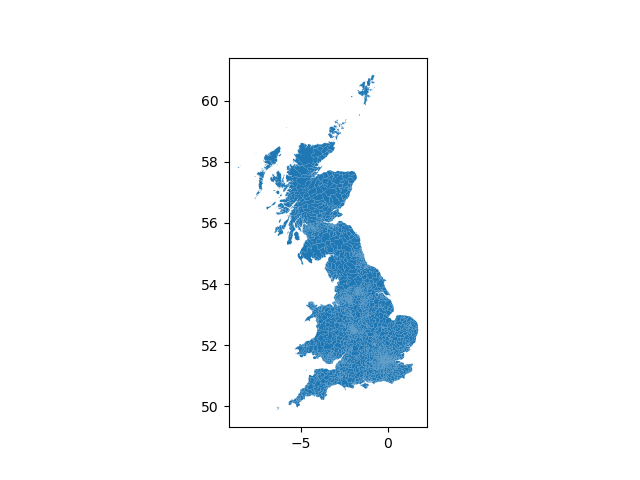

In [5]:
#Load and check map of PostCode Districts
fp = "postcodes/Districts.shp"
map_df = gpd.read_file(fp)
map_df.plot()

In [6]:
#Examine Header data of map
map_df.head()

,name,geometry
0,AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663..."
1,AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57..."
2,AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57..."
3,AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525..."
4,AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619..."


In [23]:
#Aggregate postcodes with total containers for the year
aggregate_district = slice.groupby(["Postcode_clean"])["Units"].sum().reset_index()
sorted_area = aggregate_district.sort_values(by = "Units", ascending = 0).head(20)
sorted_area['Unit_pct'] = sorted_area.Units / df.Units.sum()
sorted_area.style.format({
    'Unit_pct': '{:,.1%}'.format,
})

#TODO: Annualise & Give Monthly Average Units

,Postcode_clean,Units,Unit_pct
393,M32,1667,1.1%
219,DN40,1221,0.8%
631,TS25,963,0.6%
135,CH5,884,0.6%
380,M17,740,0.5%
171,DE14,668,0.4%
441,NG4,650,0.4%
694,WV14,622,0.4%
654,WF17,612,0.4%
562,SK5,551,0.3%


In [24]:
reset_index = map_df.set_index("name")
merged = reset_index.join(aggregate_district.set_index("Postcode_clean"))
merged["Units"] = merged["Units"].fillna(0)
merged

,geometry,Units
name,,
AB10,"POLYGON ((-2.11645 57.14656, -2.11655 57.14663...",0.0
AB11,"MULTIPOLYGON (((-2.05257 57.13426, -2.05729 57...",0.0
AB12,"MULTIPOLYGON (((-2.12807 57.03684, -2.12986 57...",0.0
AB13,"POLYGON ((-2.26153 57.10694, -2.27015 57.11525...",0.0
AB14,"POLYGON ((-2.26153 57.10694, -2.26315 57.10619...",0.0
...,...,...
YO90,"MULTIPOLYGON (((-1.08958 53.95931, -1.08891 53...",0.0
YO91,"POLYGON ((-1.06530 53.97796, -1.06634 53.97830...",0.0
ZE1,"MULTIPOLYGON (((-1.17282 60.12108, -1.18797 60...",0.0


<IPython.core.display.Javascript object>


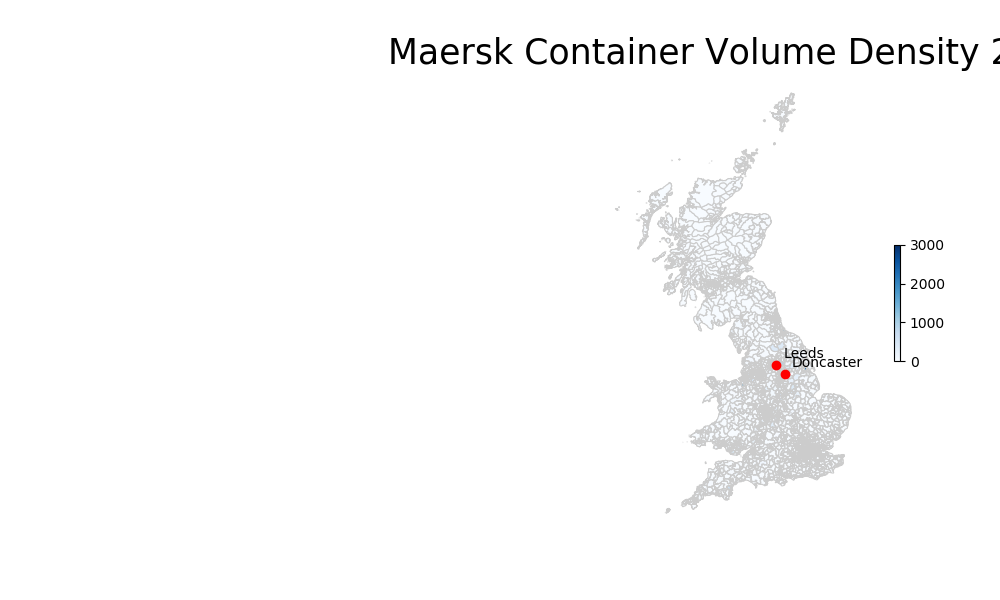

In [25]:
variable = "Units"
vmin, vmax = 0, 3000
fig, ax = plt.subplots(1, figsize=(10, 6))

# add a title and remove axis
ax.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, fraction=0.0075, pad=0.04)


ax.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")


merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
fl_points.plot(ax=ax, color="red")



# Postcode Area-level analysis (e.g., LN)

<IPython.core.display.Javascript object>


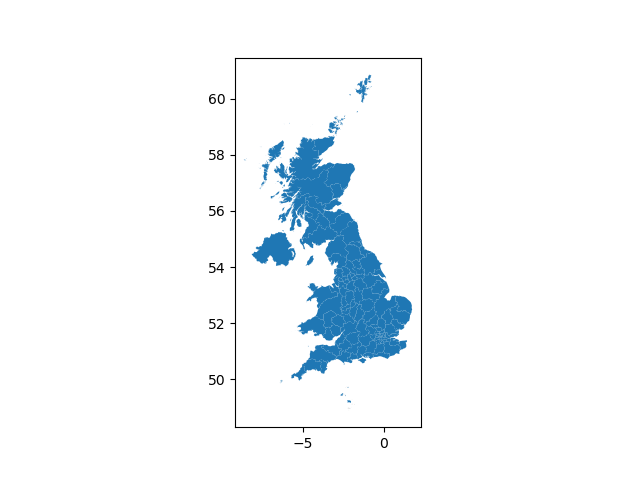

In [26]:
#Load and check map of PostCode Districts
fp_areas = "postcodes/Areas.shp"
map_df_areas = gpd.read_file(fp_areas)
map_df_areas.plot()

In [27]:
# Create Column with Postcode Area (one or two letters)
area_df = slice

In [28]:
#Aggregate postcodes with total containers for the year
aggregate_area = area_df.groupby(["PC_Area"])["Units"].sum().reset_index()
aggregate_area.describe()

,Units
count,66.000000
mean,585.893939
std,760.806154
min,1.000000
25%,101.750000
50%,295.000000
75%,824.250000
max,3869.000000


In [29]:
reset_index = map_df_areas.set_index("name")
merged_area = reset_index.join(aggregate_area.set_index("PC_Area"))
merged_area["Units"] = merged_area["Units"].fillna(0)
merged_area

,geometry,Units
name,,
AB,"POLYGON ((-2.21091 56.88580, -2.21858 56.88676...",0.0
AL,"POLYGON ((-0.37138 51.68730, -0.37227 51.68781...",0.0
B,"POLYGON ((-2.05436 52.24756, -2.05530 52.25006...",2660.0
BA,"POLYGON ((-2.08430 51.31717, -2.08008 51.31421...",144.0
BB,"POLYGON ((-2.21557 53.73160, -2.21541 53.73145...",952.0
...,...,...
ZE,"MULTIPOLYGON (((-0.80210 60.40932, -0.80233 60...",0.0
BT,"MULTIPOLYGON (((-5.54258 54.29000, -5.54922 54...",0.0
GY,"MULTIPOLYGON (((-2.36625 49.40170, -2.36750 49...",0.0


In [14]:
nomi = pgeocode.Nominatim('GB')
nomi.query_postal_code("S9 1")

postal_code                                S9
country_code                               GB
place_name        Tinsley, Darnall, Wincobank
state_name                            England
state_code                                ENG
county_name                   South Yorkshire
county_code                           2637273
community_name                            NaN
community_code                            NaN
latitude                              53.4099
longitude                            -1.40847
accuracy                                    4
Name: 0, dtype: object

<IPython.core.display.Javascript object>


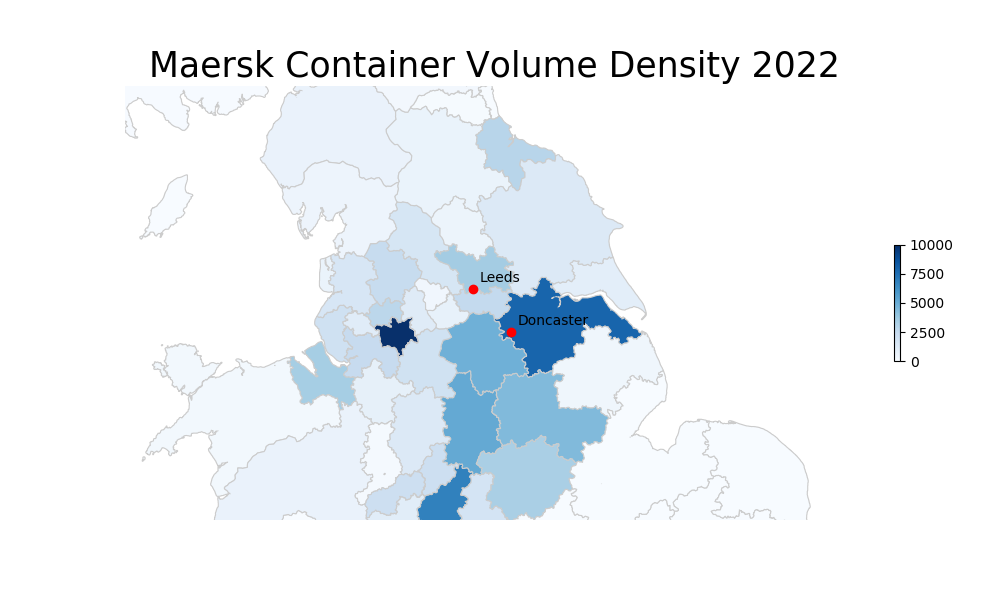

In [30]:
fig_com, ax_com = plt.subplots(1, figsize=(10, 6))
ax_com.axis('off')
vmin_area, vmax_area = 0, 10000

# add a title
ax_com.set_title("Maersk Container Volume Density 2022", fontdict={'fontsize': '25', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin_area, vmax=vmax_area))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig_com.colorbar(sm, fraction=0.0075, pad=0.04)

ax_com.annotate("Leeds", (indexed_fl_points.loc["Leeds"]["Long"], indexed_fl_points.loc["Leeds"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")
ax_com.annotate("Doncaster", (indexed_fl_points.loc["Doncaster"]["Long"], indexed_fl_points.loc["Doncaster"]["Lat"]), xycoords='data', xytext=(5,5), textcoords="offset points")

merged_area.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax_com, edgecolor='0.8') 
fl_points.plot(ax=ax_com, color="red")